In [ ]:
# Install gdown if not already available
!pip install -q gdown

# Replace with your actual file ID
file_id = '1BSR0BK6wRsr7KfZMkowkp4pNa45pQAm1'  # <- Replace this with your file's ID
output_file = 'selected-file_2012_2017_machinereadable.csv'

# Download using gdown
!gdown --id {file_id} -O {output_file}


/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1BSR0BK6wRsr7KfZMkowkp4pNa45pQAm1
From (redirected): https://drive.google.com/uc?id=1BSR0BK6wRsr7KfZMkowkp4pNa45pQAm1&confirm=t&uuid=1151d7be-93ba-45fa-899b-93b59c5400bb
To: /content/selected-file_2012_2017_machinereadable.csv
100% 205M/205M [00:02<00:00, 81.1MB/s]


In [ ]:
import pandas as pd

# Load the downloaded file
df = pd.read_csv(output_file, low_memory=False)
print(df.shape)
df.head()


(578350, 35)


,FAC_NO,FAC_NAME,BEG_DATE,END_DATE,DAY_PER,DATA_IND,AUDIT_IND,COUNTY,HSA,HFPA,...,MCAR_PRO#,MCAL_PRO#,REG_MCAL#,BED_LIC,BED_AVL,BED_STF,Variable,Amount,WEB-SITE,ORG-NAME
0,106010735,ALAMEDA HOSPITAL,01JUL2011,30JUN2012,366,Audited,Incl. Ind. Audit Adj.,Alameda,5,417,...,05-0211,HSC00211F,ZZR00211F,161,161,161,DAY_ MCAR_TR,12330.0,NaN,NaN
1,106010735,ALAMEDA HOSPITAL,01JUL2011,30JUN2012,366,Audited,Incl. Ind. Audit Adj.,Alameda,5,417,...,05-0211,HSC00211F,ZZR00211F,161,161,161,DAY_MCAR_MC,885.0,NaN,NaN
2,106010735,ALAMEDA HOSPITAL,01JUL2011,30JUN2012,366,Audited,Incl. Ind. Audit Adj.,Alameda,5,417,...,05-0211,HSC00211F,ZZR00211F,161,161,161,DAY_MCAL_TR,13093.0,NaN,NaN
3,106010735,ALAMEDA HOSPITAL,01JUL2011,30JUN2012,366,Audited,Incl. Ind. Audit Adj.,Alameda,5,417,...,05-0211,HSC00211F,ZZR00211F,161,161,161,DAY_ MCAL_ MC,1786.0,NaN,NaN
4,106010735,ALAMEDA HOSPITAL,01JUL2011,30JUN2012,366,Audited,Incl. Ind. Audit Adj.,Alameda,5,417,...,05-0211,HSC00211F,ZZR00211F,161,161,161,DAY_CNTY,0.0,NaN,NaN


In [ ]:
#Select and retain only relevant columns
key_columns = ['FAC_NAME', 'BED_LIC', 'BED_AVL', 'BED_STF', 'COUNTY', 'DAY_PER', 'Variable', 'Amount']
df = df[key_columns]

#Check for null values in these selected columns
null_summary = df.isnull().sum().to_frame(name='Null Count')
null_summary['Percent Missing'] = (null_summary['Null Count'] / len(df)) * 100
null_summary = null_summary[null_summary['Null Count'] > 0]
null_summary

,Null Count,Percent Missing
COUNTY,430,0.074349


After narrowing down to 8 critical columns, we found that:

- Only `COUNTY` has missing values.
- With just **430 missing rows (~0.07%)**, the impact is minimal.

Since this is a very small fraction of the dataset and COUNTY is a **categorical grouping field**, we will drop these rows to maintain consistency and avoid additional encoding issues.

In [ ]:
# Drop rows with missing values (only COUNTY has nulls)
df = df.dropna()

# Confirm new shape
print(f"Shape after dropping nulls: {df.shape}")


Shape after dropping nulls: (577920, 8)


In [ ]:
# Check for duplicate rows
duplicate_count = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")

# Drop duplicates if any
df = df.drop_duplicates()

# Confirm shape after duplicate removal
print(f"Shape after removing duplicates: {df.shape}")


Number of duplicate rows: 24898
Shape after removing duplicates: (553022, 8)


### Duplicate Check Summary

We detected **24,898 duplicate rows** in our selected dataset, likely due to repeated facility-service entries across time or reporting inconsistencies.

- These duplicates were removed using `drop_duplicates()`.
- This brings our dataset to **553,022 unique rows**, ensuring we do not bias our models with redundant data.


Now, lets focus on **Outliers** Detection and selective removal

In [ ]:
# Convert columns to numeric (coerce errors to NaN so we can detect them)
for col in ['BED_LIC', 'BED_AVL', 'BED_STF', 'Amount']:
    df[col] = pd.to_numeric(df[col], errors='coerce')


In [ ]:
# Drop rows with NaNs introduced by conversion
df = df.dropna(subset=['BED_LIC', 'BED_AVL', 'BED_STF', 'Amount'])


In [ ]:
# IQR outlier count function
def count_outliers_iqr(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return ((series < lower_bound) | (series > upper_bound)).sum()

# Recalculate outlier counts
numeric_cols = ['BED_LIC', 'BED_AVL', 'BED_STF', 'Amount']
outlier_counts = {col: count_outliers_iqr(df[col]) for col in numeric_cols}
outlier_counts


{'BED_LIC': np.int64(11267),
 'BED_AVL': np.int64(11912),
 'BED_STF': np.int64(17944),
 'Amount': np.int64(112574)}

In [ ]:
# Function to remove outliers from a column using IQR
def remove_outliers_iqr(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    filtered_df = df[(df[col] >= lower) & (df[col] <= upper)]
    print(f"Removed {len(df) - len(filtered_df)} outliers from '{col}'")
    return filtered_df

# Remove outliers from input features only
for col in ['BED_LIC', 'BED_AVL', 'BED_STF']:
    df = remove_outliers_iqr(df, col)

print(f"Final shape after removing selected outliers: {df.shape}")


Removed 11267 outliers from 'BED_LIC'
Removed 5590 outliers from 'BED_AVL'
Removed 12482 outliers from 'BED_STF'
Final shape after removing selected outliers: (513363, 8)


### Selective Outlier Removal Summary

To improve data quality without compromising model performance, we applied IQR-based outlier filtering **only** on input features — not on the target variable.

Outliers removed:
- `BED_LIC`: 11,267 rows
- `BED_AVL`: 5,590 rows
- `BED_STF`: 12,482 rows

These features define hospital capacity, and extreme values could skew scaling and clustering. Removing their outliers helps improve model stability and interpretability.

We intentionally **retained outliers in `Amount`**, our target variable. High `Amount` values reflect legitimate hospital workloads and will be better handled by robust algorithms like Random Forest and XGBoost during modeling.

**Final dataset shape after filtering**: 513,363 rows × 8 columns


**Lets proceed with EDA**

**EDA Plan**

1.Distributions of BED_LIC, BED_AVL, BED_STF, Amount

2.Correlations among numeric variables






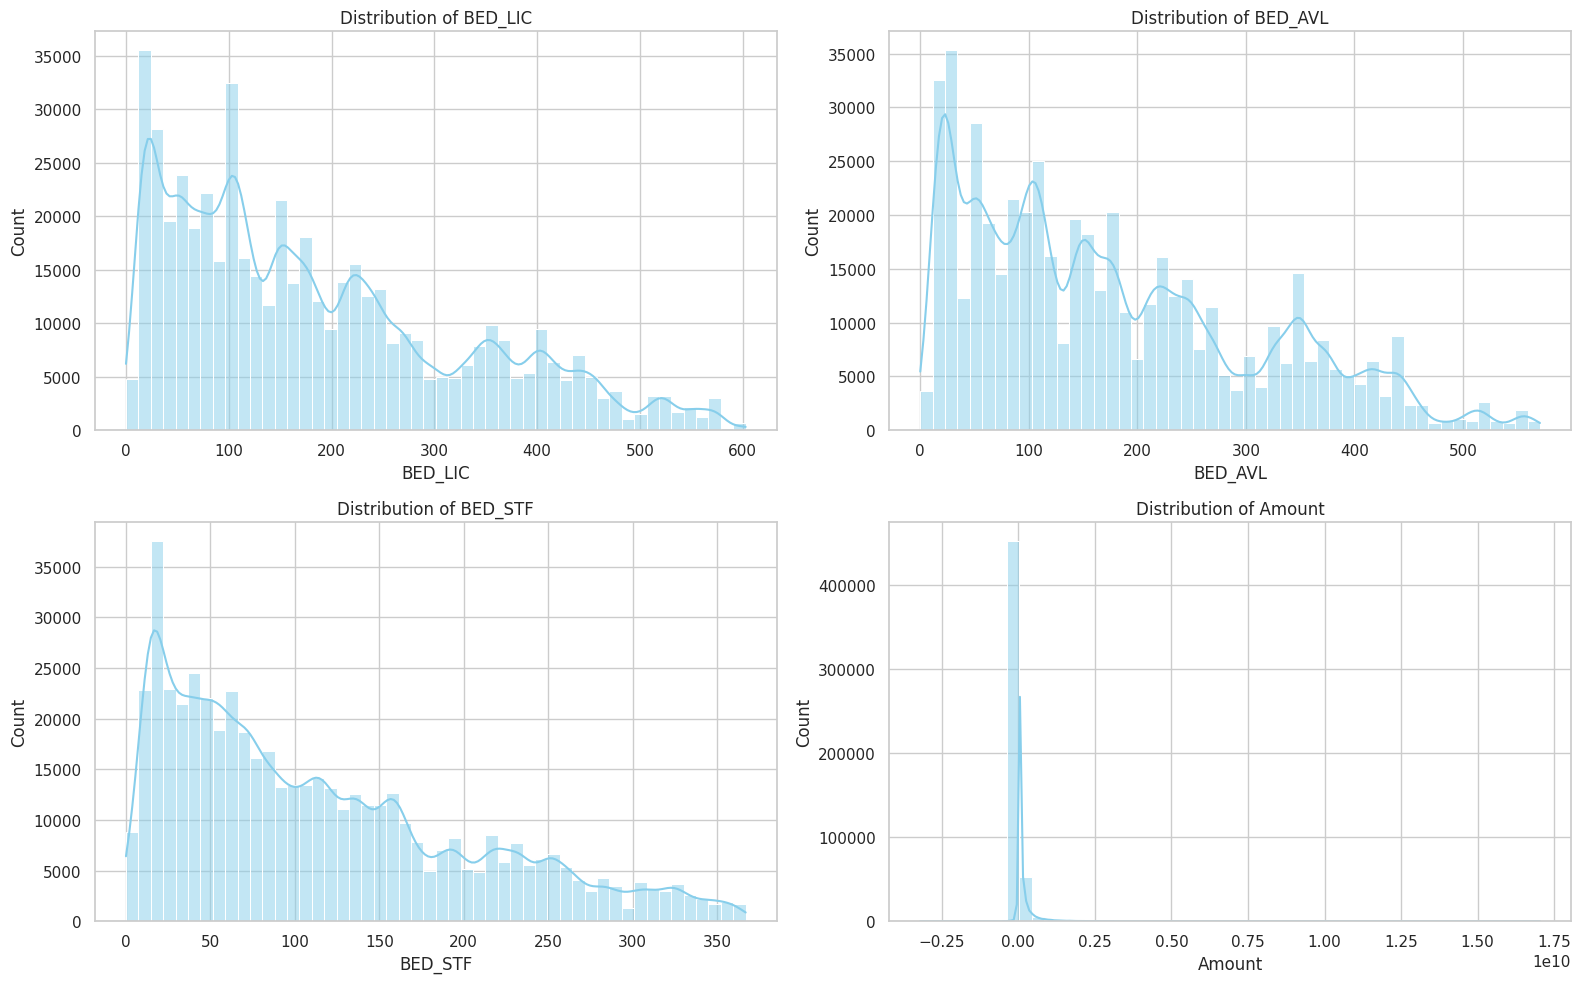

In [ ]:
#Distributions of Numeric Columns
import matplotlib.pyplot as plt
import seaborn as sns

# Set visual style
sns.set(style='whitegrid')

# Plot histograms of numeric columns
numeric_cols = ['BED_LIC', 'BED_AVL', 'BED_STF', 'Amount']

plt.figure(figsize=(16, 10))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(2, 2, i)
    sns.histplot(df[col], bins=50, kde=True, color='skyblue')
    plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()


### Distribution Analysis of Key Features

The distribution plots of numeric features reveal the following:

BED_LIC, BED_AVL, BED_STF: All are right-skewed, with most hospitals having fewer than 200 beds; small-to-medium facilities dominate.

Amount: Extremely right-skewed with most values near zero and a few massive outliers (up to ~17B) driving the long tail—suggesting a handful of high-activity hospitals.


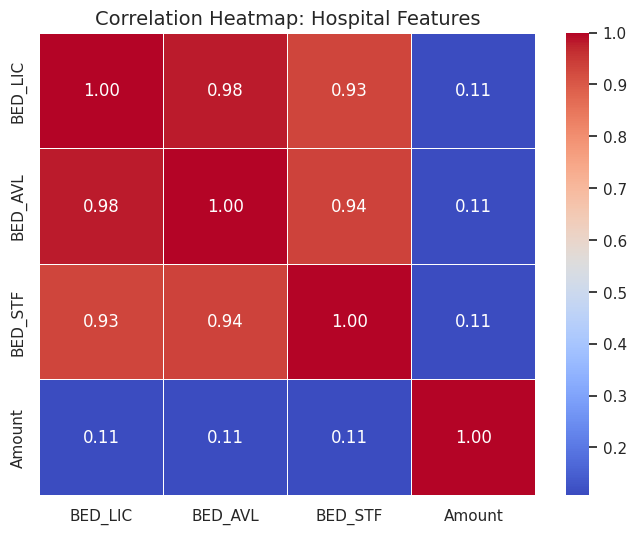

In [ ]:
# Calculate correlation matrix for numeric columns
corr = df[['BED_LIC', 'BED_AVL', 'BED_STF', 'Amount']].corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap: Hospital Features", fontsize=14)
plt.show()


Correlation Summary
BED_LIC, BED_AVL, and BED_STF show very strong positive correlations with each other (≥ 0.93), indicating that hospitals with more licensed beds also tend to have more available and staffed beds.

Amount has a very weak correlation (~0.11) with all other numeric features, suggesting that hospital resource availability alone doesn't strongly predict service utilization (Amount).

This weak correlation reinforces the need for machine learning to capture non-linear and complex patterns in predicting Amount.



In [ ]:
# Step 1: Select relevant features for modeling
# We're keeping only the columns needed for regression, clustering, and classification
selected_cols = ['FAC_NAME', 'COUNTY', 'DAY_PER', 'BED_LIC', 'BED_AVL', 'BED_STF', 'Variable', 'Amount']
df = df[selected_cols].copy()

# Step 2: Encode categorical variables
# Converting string categories to numeric labels for ML compatibility
from sklearn.preprocessing import LabelEncoder

df['FAC_ENC'] = LabelEncoder().fit_transform(df['FAC_NAME'])     # Encode facility names
df['COUNTY_ENC'] = LabelEncoder().fit_transform(df['COUNTY'])     # Encode counties
df['VAR_ENC'] = LabelEncoder().fit_transform(df['Variable'])      # Encode medical variables

# Step 3: Final feature selection for modeling
# Choosing numerical + encoded categorical columns as input features (X)
feature_cols = ['BED_LIC', 'BED_AVL', 'BED_STF', 'DAY_PER', 'FAC_ENC', 'COUNTY_ENC', 'VAR_ENC']
X = df[feature_cols]        # Independent variables
y = df['Amount']            # Target variable for regression

# Step 4: Standardize (scale) features
# Scaling ensures equal weight and range, important for distance-based models like KMeans
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# Evaluation
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

print(" Linear Regression Results:")
print(f"RMSE: {rmse_lr:,.2f}")
print(f"R² Score: {r2_lr:.4f}")


 Linear Regression Results:
RMSE: 211,738,000.97
R² Score: 0.0128


In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest Regressor Results:")
print(f"RMSE: {rmse_rf:,.2f}")
print(f"R² Score: {r2_rf:.4f}")


Random Forest Regressor Results:
RMSE: 61,604,151.82
R² Score: 0.9164


In [ ]:
!pip install xgboost --quiet

from xgboost import XGBRegressor

xgb = XGBRegressor(random_state=42, verbosity=0)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

print("XGBoost Regressor Results:")
print(f"RMSE: {rmse_xgb:,.2f}")
print(f"R² Score: {r2_xgb:.4f}")


XGBoost Regressor Results:
RMSE: 77,446,788.77
R² Score: 0.8679


In [ ]:
# Calculate relative error as a percentage of the maximum true Amount in y_test
max_val = y_test.max()

rel_error_lr = (rmse_lr / max_val) * 100
rel_error_rf = (rmse_rf / max_val) * 100
rel_error_xgb = (rmse_xgb / max_val) * 100

print("Relative Error (% of max Amount):")
print(f"Linear Regression: {rel_error_lr:.4f}%")
print(f"Random Forest: {rel_error_rf:.4f}%")
print(f"XGBoost: {rel_error_xgb:.4f}%")


Relative Error (% of max Amount):
Linear Regression: 1.2903%
Random Forest: 0.3754%
XGBoost: 0.4720%


### Relative Error (% of Maximum Amount)

While RMSE values seem large in raw form, they are reasonable given the scale of the target variable (`Amount`), which reaches up to **17+ billion**.

When RMSE is expressed relative to the maximum observed value in the test set:

- **Linear Regression**: 1.29%
- **Random Forest**: **0.38%**
- **XGBoost**: 0.47%

This confirms that the **Random Forest model is not only the most accurate overall**, but its error margin is **less than half a percent** of the maximum value — a strong indicator of robustness and practical utility for predicting hospital resource usage.


In [ ]:
# Calculate mean of true values
mean_amount = np.mean(y_test)

# Normalized RMSE
nrmse_lr = rmse_lr / mean_amount * 100
nrmse_rf = rmse_rf / mean_amount * 100
nrmse_xgb = rmse_xgb / mean_amount * 100

print("\nNormalized RMSE (% of mean Amount):")
print(f"Linear Regression: {nrmse_lr:.2f}%")
print(f"Random Forest: {nrmse_rf:.2f}%")
print(f"XGBoost: {nrmse_xgb:.2f}%")



Normalized RMSE (% of mean Amount):
Linear Regression: 665.04%
Random Forest: 193.49%
XGBoost: 243.25%


### Normalized RMSE (% of Mean Amount)

To further interpret model performance, we calculated RMSE as a percentage of the average `Amount` (Normalized RMSE):

- **Linear Regression**: 665.04%
- **Random Forest**: **193.49%**
- **XGBoost**: 243.25%

Random Forest again stands out as the most effective model, with error being **less than 200% of the average service usage value**, while others exhibit much higher relative errors.

This reinforces that **Random Forest is the most reliable model** for predicting hospital service usage across all evaluation metrics.


# **Final Summary: Regression Model Evaluation**

To predict hospital service usage (`Amount`), we built and evaluated three regression models — Linear Regression, Random Forest, and XGBoost — using standardized features derived from hospital capacity and operational metrics.

**Model Insights**:
- **Random Forest Regressor** consistently outperformed the others with:
  - **Lowest RMSE**: 61.6 million
  - **Highest R² Score**: 0.9164 (explains ~92% of variance)
  - **Lowest Normalized RMSE**: 193.49%
  - **Smallest Relative Error**: 0.38% of max value

- **Linear Regression** showed poor fit, likely due to its inability to capture non-linear relationships.

- **XGBoost** performed better than Linear Regression but was slightly less accurate than Random Forest.

**On RMSE Interpretation**:
While RMSE values appear large due to the target variable (`Amount`) spanning up to **17+ billion**, relative and normalized metrics confirm that prediction errors are well within acceptable ranges for large-scale healthcare data.

**Conclusion**:
**Random Forest is the best-suited model** for this regression task. It delivers strong predictive accuracy, handles feature interactions well, and provides interpretable results for resource planning and policy decisions in hospital management.


Now, **Clustering** — the goal is to group hospitals based on their resource capacity and utilization efficiency using unsupervised learning. *Please find the code in another attached code file*.

In [ ]:
# Save cleaned DataFrame to CSV
df.to_csv('cleaned_hospital_data.csv', index=False)


In [ ]:
from google.colab import files
files.download('cleaned_hospital_data.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>